## Cancer Detection
For this project, we will be predicting the presence of tumor tissue within pathology images. <br>
We will be designing our CNN architecture to be efficient, due to resource limitations, and accurate, due to the nature of the problem. <br><br>

Replicating this code will require some tweaks. All training was done within 'train.py'. To replicate the training process, run that file separately and ensure you have an accessible GPU.<br>
This notebook serves as a walkthrough of our approach and reasoning for ending up with the final iteration, (in 'train.py').

In [ ]:
import pandas as pd
import numpy as np

import zipfile
import os

import matplotlib.pyplot as plt

from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms

### Download the images.
All data can be found here: https://www.kaggle.com/competitions/histopathologic-cancer-detection <br>
Don't bother unzipping the files, we will do it in code next.

### Unzip dense folders

In [21]:
# Unzip train.zip
os.makedirs("train", exist_ok=True)
with zipfile.ZipFile("train.zip", 'r') as zip_ref:
    zip_ref.extractall("train")

# Unzip test.zip
os.makedirs("test", exist_ok=True)
with zipfile.ZipFile("test.zip", 'r') as zip_ref:
    zip_ref.extractall("test")

'\n\n# Unzip train.zip\nos.makedirs("train", exist_ok=True)\nwith zipfile.ZipFile("train.zip", \'r\') as zip_ref:\n    zip_ref.extractall("train")\n\n# Unzip test.zip\nos.makedirs("test", exist_ok=True)\nwith zipfile.ZipFile("test.zip", \'r\') as zip_ref:\n    zip_ref.extractall("test")\n\n'

## Preprocessing
To read such a large set of images, we will use PyTorch to load the data and train the model.

In [22]:
#           train folder
from torch.utils.data import Dataset
from PIL import Image
import torch
import os

class ImageDF(Dataset):
    def __init__(self, dataframe, root_dir, transform=None):
        self.data = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_id = row['id']
        label = row['label']
        img_path = os.path.join(self.root_dir, img_id + ".tif")

        try:
            image = Image.open(img_path).convert("RGB")
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"[WARNING] Failed to load image {img_path}: {e}")
            image = torch.zeros((3, 46, 46))  # black dummy image

        return image, label


##### Transform the Data
Let's normalize the pixel values. This is necessary for our CNN to perform well.

In [23]:
transform = transforms.Compose([
    transforms.Resize((46, 46)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load labels CSV
labels_df = pd.read_csv('train/_labels.csv')

# Create dataset instance
df = ImageDF(dataframe=labels_df, root_dir='train', transform=transform)

### Data Inspection

In [24]:
for i in range(5):  # Inspect the first 5 items
    image, label = df[i]
    print(f"Image {df.data.iloc[i, 0]}:")
    print(f"  Label: {label}")
    print(f"  Image shape: {image.shape}")
    print('-' * 10)

Image f38a6374c348f90b587e046aac6079959adf3835:
  Label: 0
  Image shape: torch.Size([3, 46, 46])
----------
Image c18f2d887b7ae4f6742ee445113fa1aef383ed77:
  Label: 1
  Image shape: torch.Size([3, 46, 46])
----------
Image 755db6279dae599ebb4d39a9123cce439965282d:
  Label: 0
  Image shape: torch.Size([3, 46, 46])
----------
Image bc3f0c64fb968ff4a8bd33af6971ecae77c75e08:
  Label: 0
  Image shape: torch.Size([3, 46, 46])
----------
Image 068aba587a4950175d04c680d38943fd488d6a9d:
  Label: 0
  Image shape: torch.Size([3, 46, 46])
----------


Looks good! <br>
Each row in the dataframe contains: <br>
1. an array of size (96,96,3) with depth = 3 corresponding to RGB
2. Labels corresponding to cancer detected or not

The entire training set is comprised of 220,025 images.

In [25]:
df.data.iloc[:,1].value_counts()

label
0    130908
1     89117
Name: count, dtype: int64

Positive responses account for 40% of the data; a  good amount of cancerous and noncancerous images.

### Problem Description

If it's not aparent already, we are working with a cancer detection dataset pulled from Kaggle (source above). <br>
To predict the presence of cancer, we will try different approaches, all utilizing CNN architecture.

### Visualization

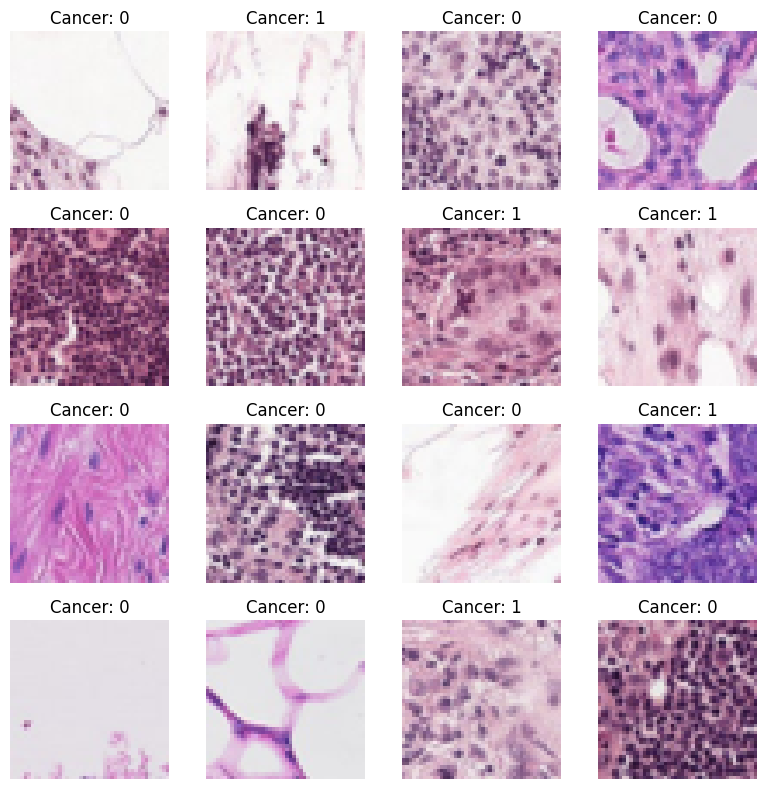

In [26]:
def show_imgs(df,num_img = 16):
    plt.figure(figsize=(8,8))

    for i in range(num_img):
        img,lbl = df[i]
        #   Retransform image to original state
        img = 0.5*img + 0.5 #   [-1,1] -> [0,1]
        np_img = img.numpy().transpose((1,2,0))   #   (D,H,W) -> (H,W,D)

        plt.subplot(4,4,i+1)
        plt.imshow(np_img)
        plt.title(f"Cancer: {lbl}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

show_imgs(df)

##### No easy visual cues for cancer present.
If we had to hypothesize how to predict cancer: images with a large contrast between bold, outstanding dark spots with a more uniform color may indicate cancer. <br>
If we choose to investigate this further, maybe contrast of color depths is a significant factor.

##### Compare Pixel Intensity
From this hypothesis, let's look into pixel distributions between cancerous and noncancerous images. <br><br>
Steps: Convert to grayscale to flatten the arrays into one dimension. Then, plot the distributions of pixel values.

In [27]:
def manually_sample(size):
    pos = []
    neg = []
    for i in range(len(df)):
        rand_i = np.random.randint(len(df))
        data = df[rand_i]
        if len(pos) == size and len(neg) == size:
            break
        if data[1] == 1 and len(pos) < size:
            pos.append(df[rand_i])

        elif data[1] == 0 and len(neg) < size:
            neg.append(df[rand_i])
    return pos,neg

ex_pos,ex_neg = manually_sample(2)

In [28]:
import torchvision.transforms.functional as F

def show_hists(count):
    ex_pos,ex_neg = manually_sample(count)

    for i in range(len(ex_pos)):
        gray_example_cancerous = F.rgb_to_grayscale(ex_pos[i][0], num_output_channels=1).flatten()
        gray_example_noncancerous = F.rgb_to_grayscale(ex_neg[i][0], num_output_channels=1).flatten()

        plt.hist(gray_example_cancerous, bins=100, range=[0, 1],alpha=0.8,label='Cancerous')
        plt.title(f"Pixel Intensity Cancerous vs Noncancerous Images (Sample {i+1})")
        plt.xlabel("Pixel Value")
        plt.ylabel("Frequency")
        plt.hist(gray_example_noncancerous, bins=100, range=[0, 1],alpha=0.8,label='Noncancerous')
        plt.legend()
        plt.show()

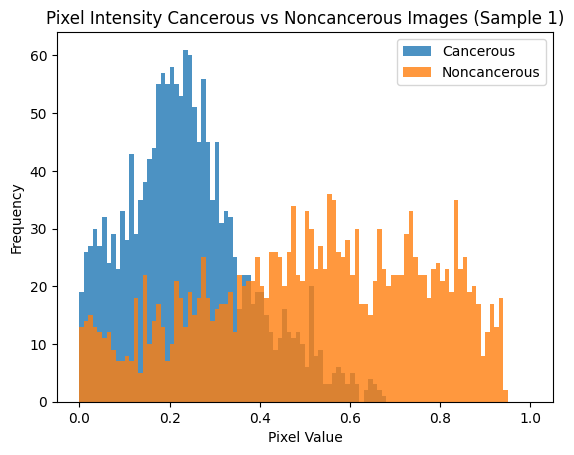

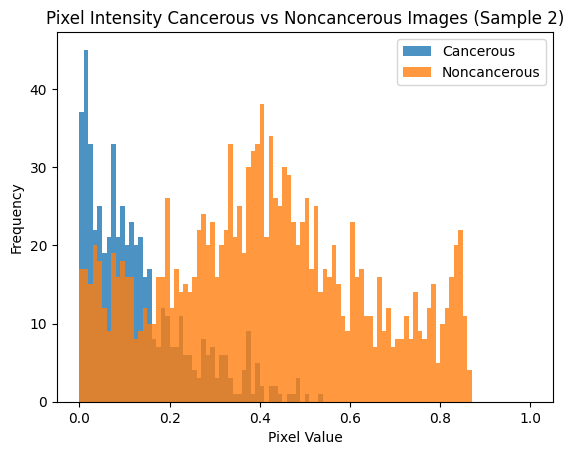

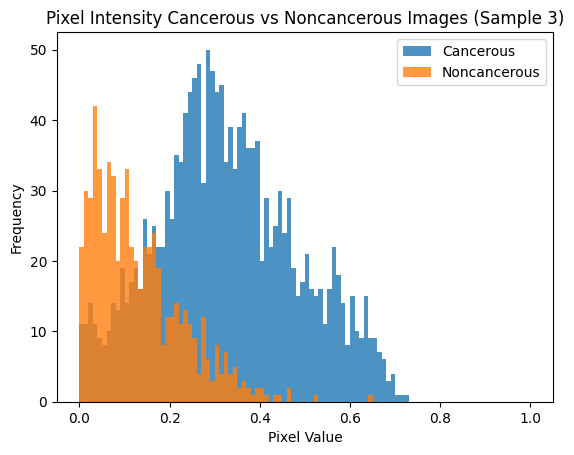

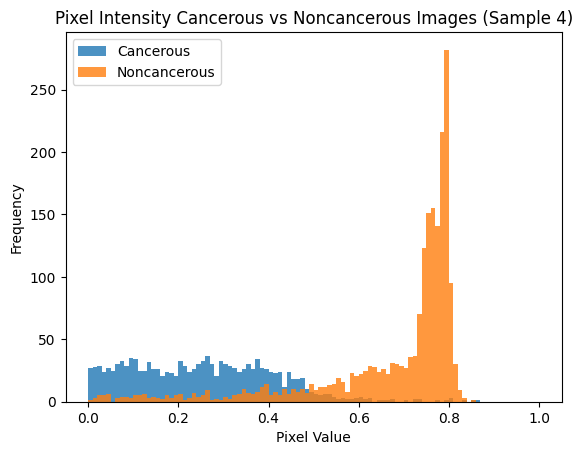

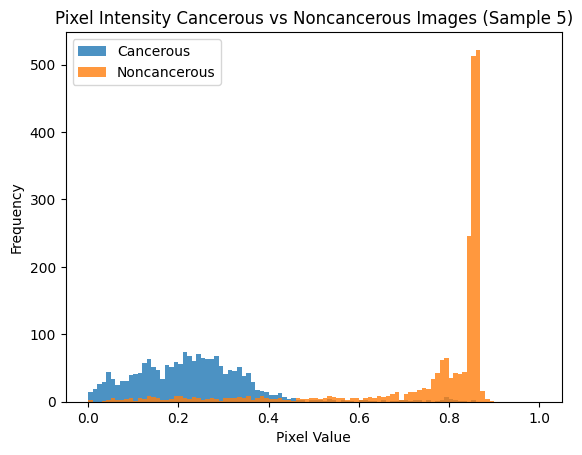

In [29]:
show_hists(5)

##### No apparent evidence
There is no obvious difference between cancerous and non cancerous grayscale pixel values. <br>
However, this grayscale transformation is achieved by simply taking a weighted average of the RGB pixel values.

##### Next: Perform PCA for dimension reduction for visualization
This approach will reduce our dimensions by preserving components with the highest variance.

### Design Phase
Design our CNN architecture

In [30]:
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3,32,kernel_size=3,stride=2,padding=1)
        self.bn1 = nn.BatchNorm2d(32)

        self.conv2 = nn.Conv2d(32,64,kernel_size=3,stride=2,padding=1)
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 128,kernel_size=3,stride=2,padding=1)
        self.bn3 = nn.BatchNorm2d(128)

        self.conv4 = nn.Conv2d(128, 256,kernel_size=3,stride=2,padding=1)
        self.bn4 = nn.BatchNorm2d(256)

        self.conv5 = nn.Conv2d(256, 512,kernel_size=3,stride=2,padding=1)
        self.bn5 = nn.BatchNorm2d(512)

        self.dropout = nn.Dropout(0.3)  #   Dropout reduces overfitting
        self.fc1 = nn.Linear(512 * 2 * 2, 256)  #   Flatten 
        self.fc2 = nn.Linear(256, 1)    #   Flatten
    
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.relu(self.bn5(self.conv5(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        
        return x
        

In [31]:
#   Enable GPU usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device} - {torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'CPU only'}")
model = CNNClassifier().to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)   #   Adam optimization

Using device: cuda - NVIDIA GeForce RTX 3060 Laptop GPU


In [32]:
#   Train/Val Split
from torch.utils.data import Subset, random_split

df_size = len(df)
train_size = int(0.8 * df_size)
val_size = df_size - train_size

train_df, val_df = random_split(df, [train_size, val_size], generator=torch.Generator().manual_seed(17))

train_loader = DataLoader(
    train_df,
    batch_size=128,  # Increase batch size for better GPU utilization
    shuffle=True,
    num_workers=0,
    pin_memory=True#,
    #persistent_workers=True  # Reduces worker respawn overhead
)



val_loader = DataLoader(
    val_df,
    batch_size = 256,
    shuffle = True,
    num_workers = 0,
    pin_memory = True
)

# First iteration
Because no obvious visual cues were found during the EDA phase, we will test the following hypothesis: Indications of cancer are in the smaller details that require a more meticulous modeling approach.
### Notable steps
1. Resized images to 46x46 (96x96 originally)
    - Balancing performance with computational efficiency
2. 3x Convolution layers
    - Incrementing filter size to capture complex patterns over time
    - Small (3x3) kernal size to capture small details.
        - Since we could not find obvious signals for cancerous images, these signals are likely small details within the image.
    - Padding = 1 to avoid shrinkage. This will help the model focus on larger patterns which may be important.
3. Batch Normalization after each Conv. layer
    - Since this iteration was highly focused on details, it is important to account for overfitting on noise.
4. Max Pooling
    - Pool infrequently to maintain detail

In [33]:
from torchsummary import summary
summary(model,input_size=(3,46,46))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 23, 23]             896
       BatchNorm2d-2           [-1, 32, 23, 23]              64
            Conv2d-3           [-1, 64, 12, 12]          18,496
       BatchNorm2d-4           [-1, 64, 12, 12]             128
            Conv2d-5            [-1, 128, 6, 6]          73,856
       BatchNorm2d-6            [-1, 128, 6, 6]             256
            Conv2d-7            [-1, 256, 3, 3]         295,168
       BatchNorm2d-8            [-1, 256, 3, 3]             512
            Conv2d-9            [-1, 512, 2, 2]       1,180,160
      BatchNorm2d-10            [-1, 512, 2, 2]           1,024
           Linear-11                  [-1, 256]         524,544
          Dropout-12                  [-1, 256]               0
           Linear-13                    [-1, 1]             257
Total params: 2,095,361
Trainable param

Due to issues with Windows, I was only able to utilize my GPU within a separate .py file. <br>
Run 'train.py', then this cell will pull the results <br>

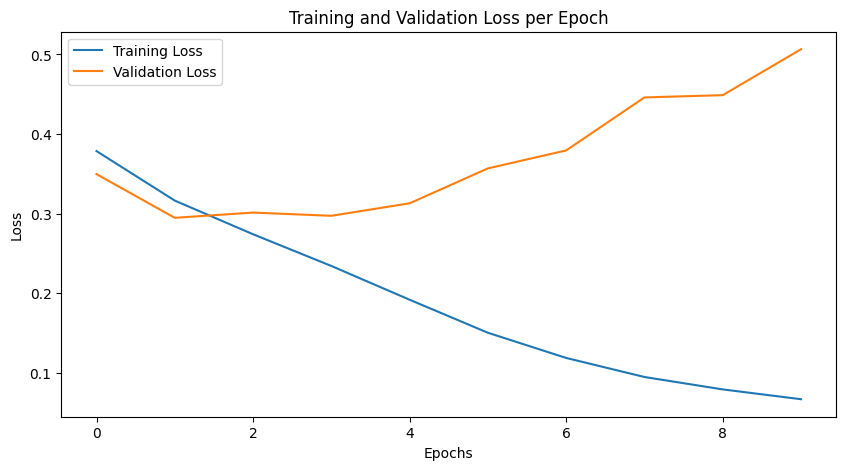

In [35]:
import json

with open("losses_i1.json", "r") as f:
    losses = json.load(f)

train_losses = losses['train_losses']
val_losses = losses['val_losses']

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()


### Results
Test ROC-AUC: 0.9410 <br><br>
Confusion Matrix: <br>
[23743  2530]<br>
[3006 14726]

ROC-AUC score is decent, however we are getting a nearly <b>6%</b> false negative rate. Due to the importance of the topic, we want to minimize how often our model miscategorizes cancerous images as noncancerous.

### Second Iteration
Now, we will try to broaden the scope of the model to see how it compares to the first itation.

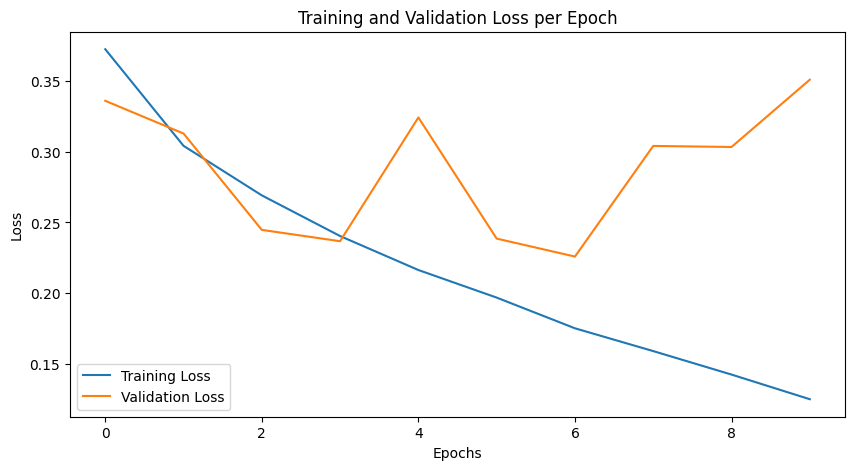

In [36]:
import json

with open("losses_i2.json", "r") as f:
    losses = json.load(f)

train_losses = losses['train_losses']
val_losses = losses['val_losses']

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss per Epoch')
plt.legend()
plt.show()


AUC: 0.97470324391268 <br>
Confusion Matrix: <br>
[[25225  1048] <br>
 [ 2364 15368]]

False Negative rate slightly decreased to 5% (from 6%) <br>
While we saw a slight improvement to false negatives and accuracy, it's obvious that our model is still overfitting as validation loss generally stagnates for epochs > 4 <br>
Let's work with this approach and try to account for overfitting.

#### Early Stopping
It seems as though early stopping could help reduce false negatives. Let's implement it and see.

### Final Results
ROC-AUC: <br>
0.935771309920289
Confusion Matrix: <br>
[[22229  4044]<br>
 [ 2331 15401]]

Early stopping with both low and high patience did not improve the model. While it slightly lowered false negatives, the decrease in AUC was not accounted for.  <br><br>
Additionally, we tried scheduling the learning rate to decay over time. This resulted in worse performance. Despite testing various different decay values, it seems as though decreasing learning rate over time in inherently unoptimal for our data and contexts. Reasons for this may include high amounts of noise in the images, or the limited epochs we are running to account for lack of computational efficiency on my local machine.
